# Image Segmentation and Cell Size Measurement
 

In [1]:
import numpy as np 
import pandas as pd 
import skimage.io 
import skimage.filters
import skimage.color
import scipy.ndimage
import scipy.interpolate
import scipy.signal
import size.viz 
import size.image
import size.analytical
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import napari
import glob
import imp 
imp.reload(size.image)
cor, pal = size.viz.matplotlib_style()

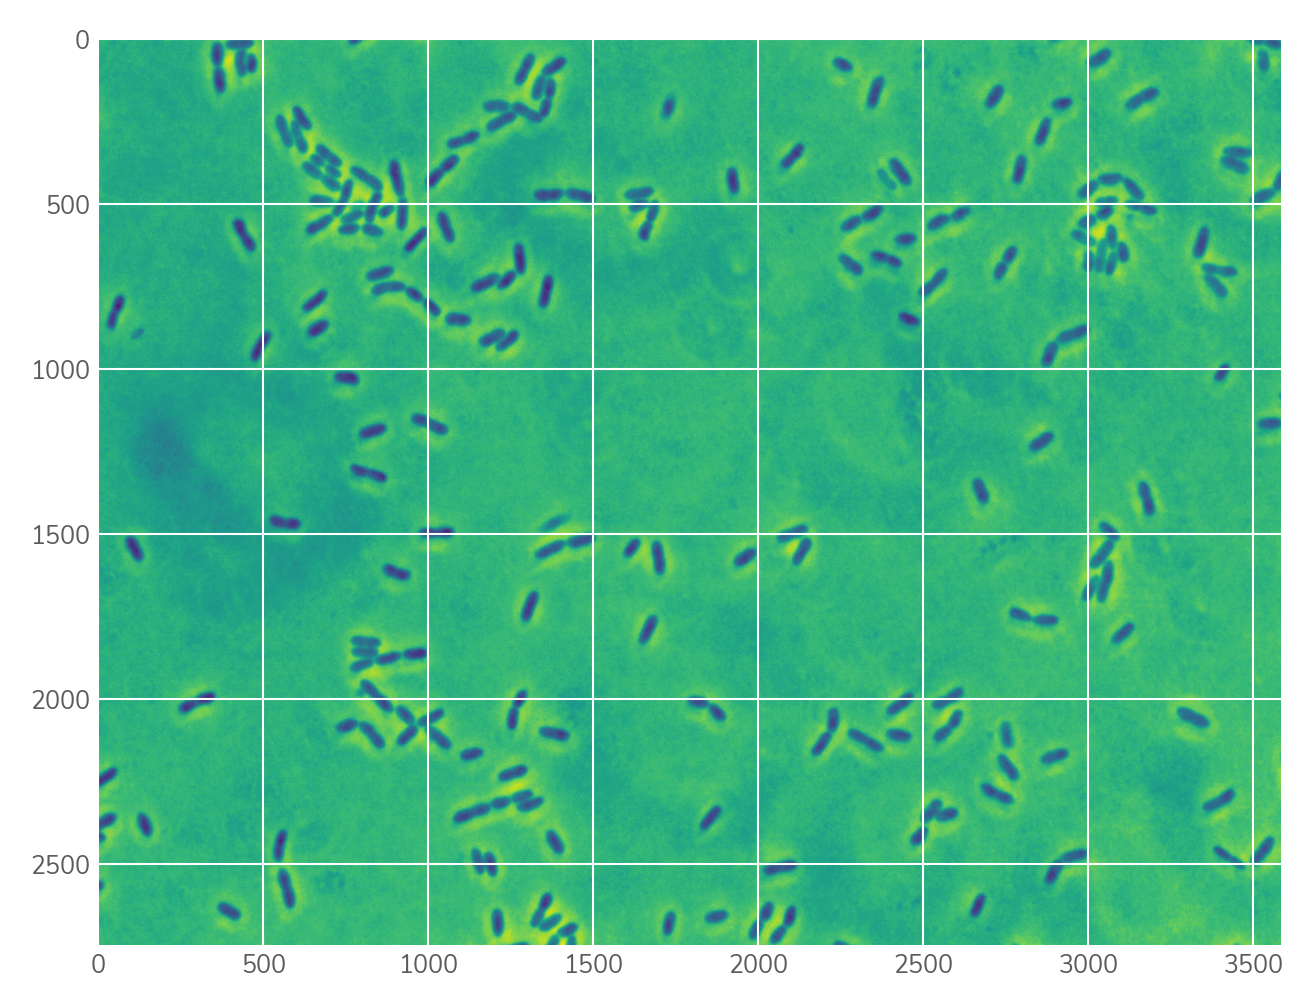

In [82]:
# Load images
files = glob.glob('../../data/images/test/*.tif') 
ims = skimage.io.ImageCollection(files)
test_im = skimage.color.rgb2gray(ims[-1])
crop = test_im#[1800:3000, 1800:]
crop = (crop - crop.min()) / (crop.max() - crop.min())
plt.imshow(crop)

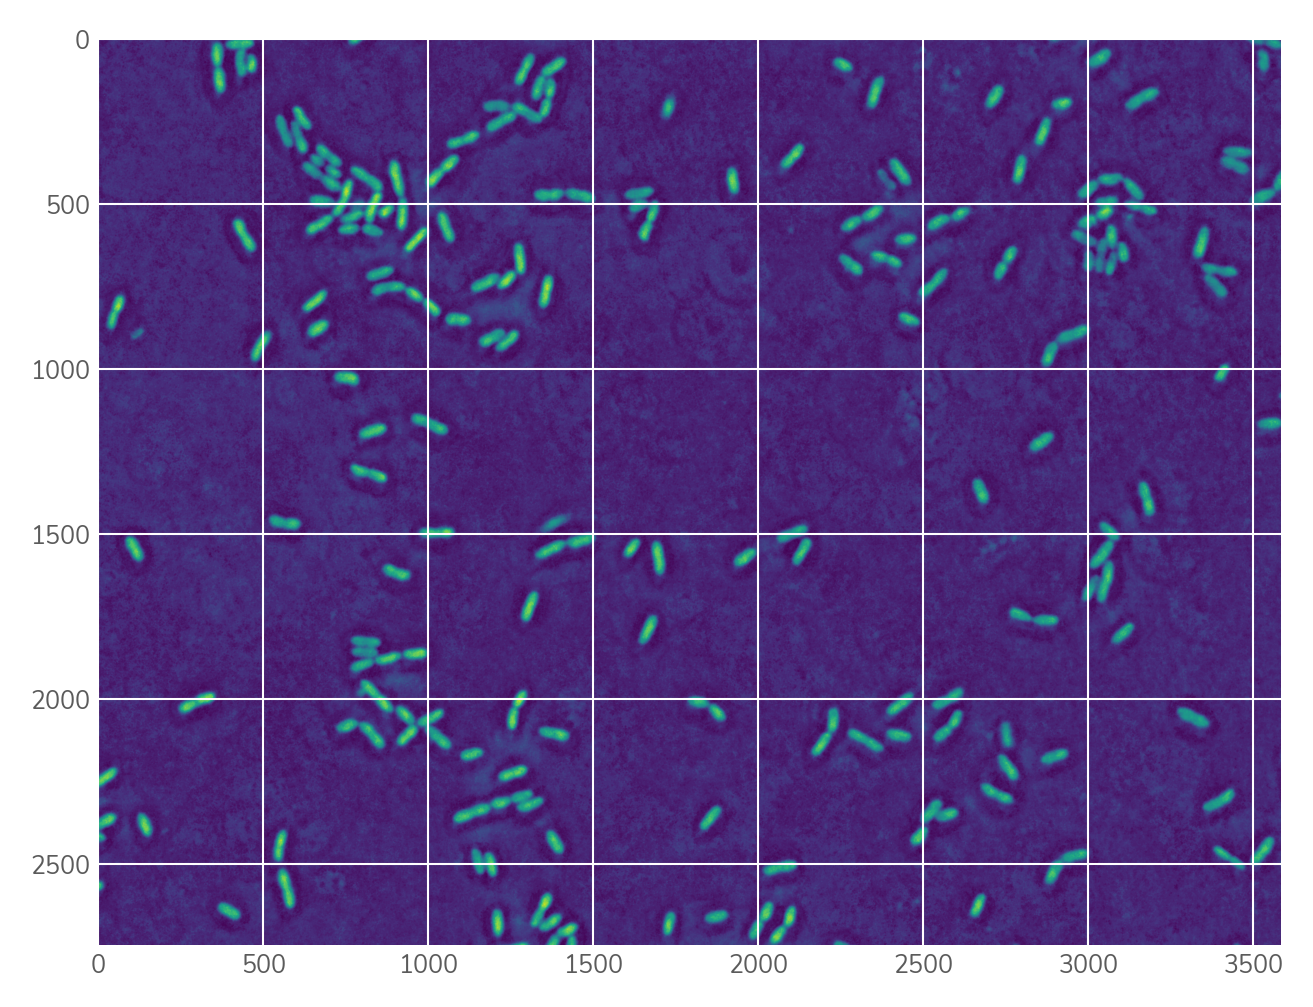

In [83]:
# # Normalize the image.
im_blur = skimage.filters.gaussian(crop, 30)
im_sub = crop - im_blur
lg_selem = skimage.morphology.disk(50)
sm_selem = skimage.morphology.disk(2)
blk_tophat = skimage.morphology.black_tophat(im_sub, lg_selem)
wht_tophat = skimage.morphology.white_tophat(blk_tophat, lg_selem)
closing = scipy.ndimage.grey_closing(wht_tophat, footprint=sm_selem)
plt.imshow(closing)

In [204]:

skimage.filters.threshold_otsu(closing)

0.23998959360711114

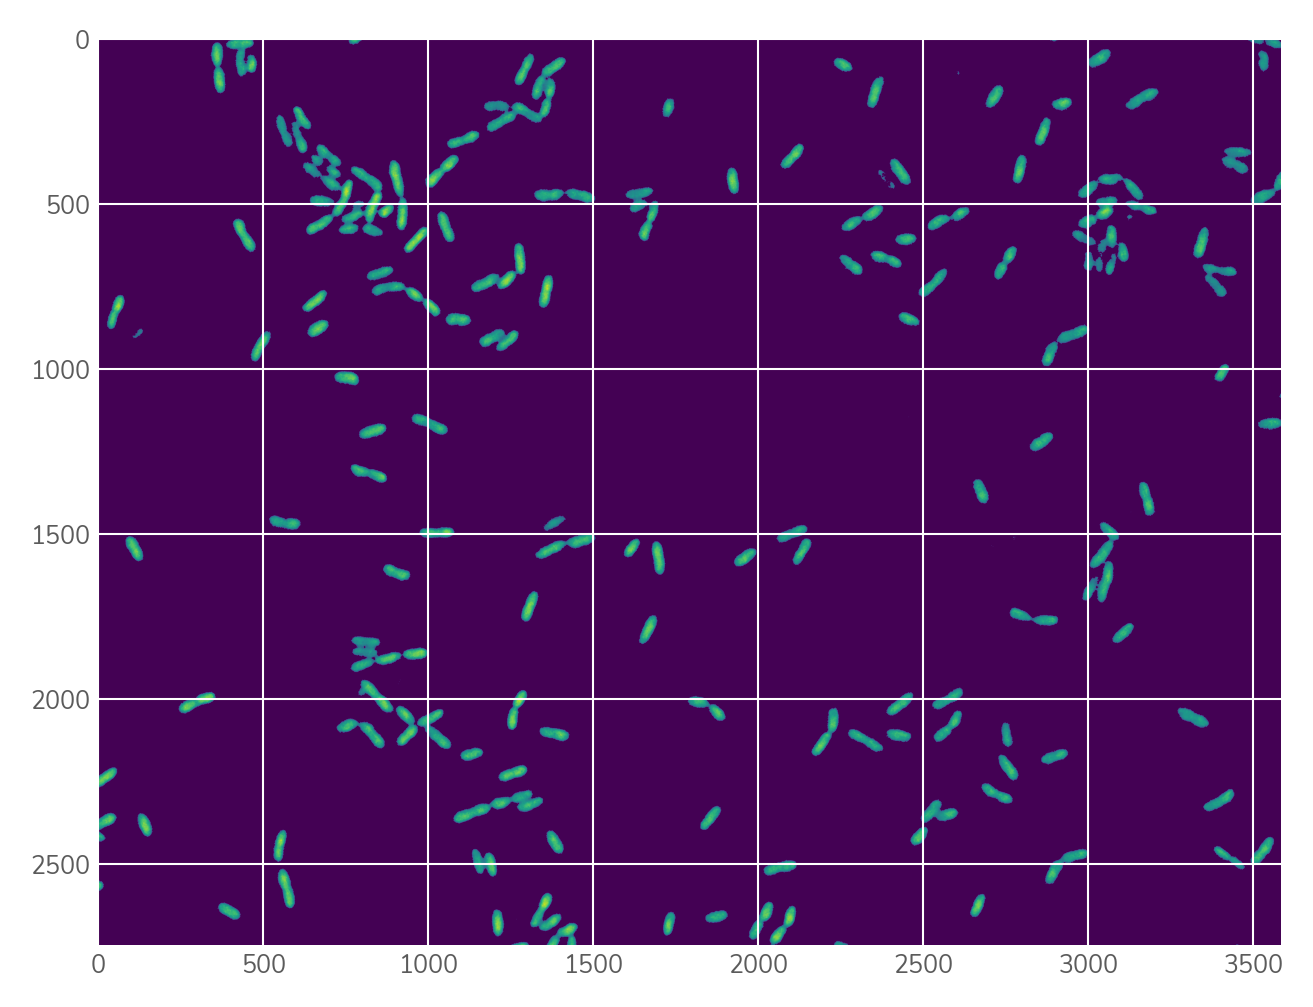

In [205]:
diff = (closing > 0.24) * closing + closing.min()
plt.imshow(diff)

In [210]:

# normed = (closing - closing.min())/(closing.max() - closing.min()) 
selem = skimage.morphology.square(2)
blur = skimage.filters.gaussian(diff, 1)
seg = size.image.log_segmentation(blur, radius=3, selem=selem, thresh=0.00001, 
                                  median_filt=False, label=False)
seg = skimage.morphology.binary_erosion(seg, sm_selem)
labeled = skimage.measure.label(seg)
objs = np.zeros_like(crop)
props = skimage.measure.regionprops(labeled)
obj_ids = []
bboxes = []
cells = []
contours = pd.DataFrame([])
idx = 0
for p in tqdm.tqdm(props):
    if ((p.area > 1E3) & (p.area < 5E3))  & (p.solidity > 0.9) & (p.eccentricity > 0.5):# & (p.intensity_max < 0.2):
        k = labeled==p.label
        objs += k
        obj_ids.append(p.label)
        rot = scipy.ndimage.rotate(labeled==p.label, -np.rad2deg(p.orientation), order=1) > 0
        relab = skimage.measure.label(rot.astype(int))
        rot_props = skimage.measure.regionprops(relab)
        level = 0
        cont = skimage.measure.find_contours(rot, level)[0]
        cx = cont[:, 1] #scipy.signal.savgol_filter(cont[:, 1], 3, 2, mode='wrap')
        cy = cont[:, 0] # scipy.signal.savgol_filter(cont[:, 0], 3, 2, mode='wrap')
        tck, u = scipy.interpolate.splprep([cx, cy], per=1, k=5, s=80)
        unew = np.arange(0, 1.0001, 0.0001)
        out = scipy.interpolate.splev(unew, tck)
        out = [list(out[0]), list(out[1])]
        dx = np.diff(out[0])
        ddx = np.diff(dx)
        dy = np.diff(out[1])
        ddy = np.diff(dy)
        k = (dx[:-1] * ddy  - dy[:-1] * ddx)/((dx[:-1]**2  + dy[:-1]**2)**(3/2))
        _df = pd.DataFrame([]) 
        _df['spl_x'] = out[0][:-2]
        _df['spl_y'] = out[1][:-2]
        _df['curvature'] = k
        _df['cell_id'] = idx
        idx += 1
        contours = pd.concat([contours, _df], sort=False)

100%|██████████| 151/151 [01:15<00:00,  1.99it/s]


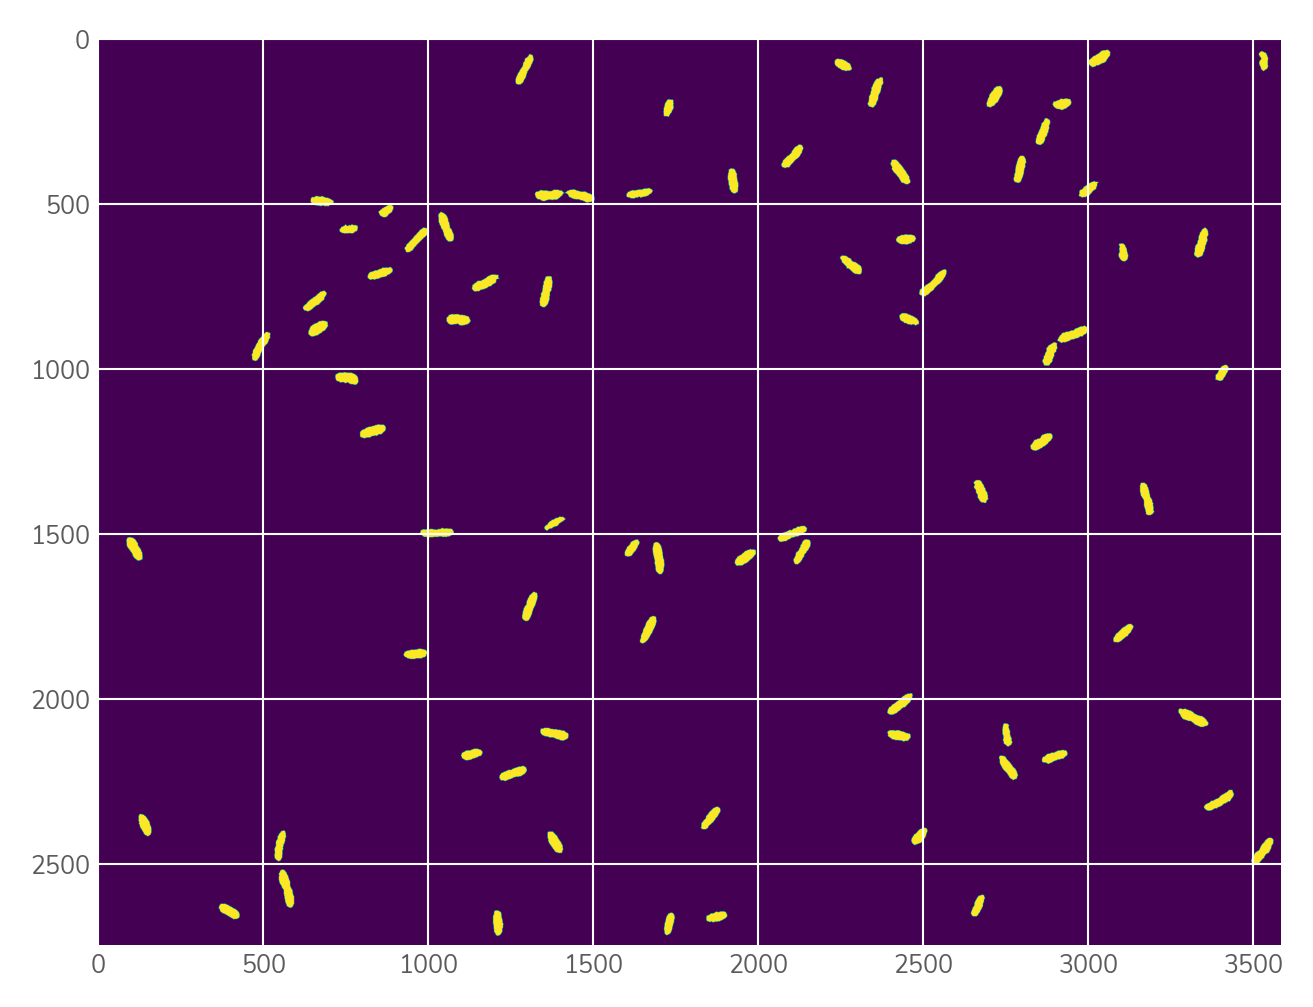

In [211]:
plt.imshow(objs)

Text(0, 0.5, 'length [µm]')

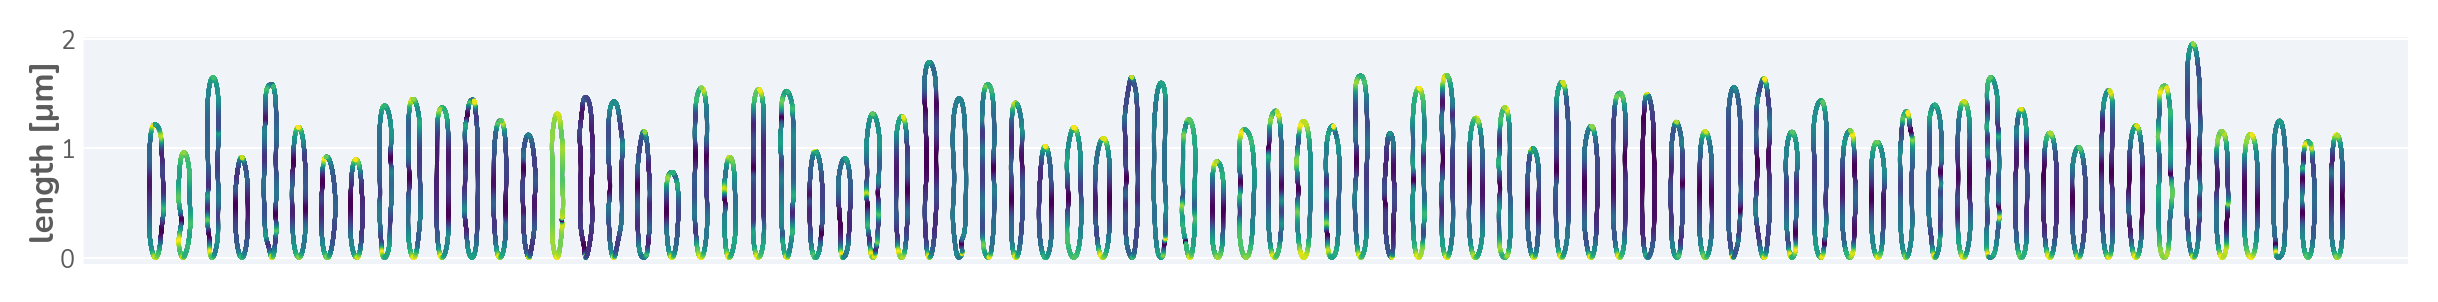

In [219]:
fig, ax = plt.subplots(1,1, figsize=(10, 1))
# ax.axis('equal')
i = 0 
for g, d in contours.groupby('cell_id'):
    # if len(d[d['curvature'] <= -0.08]) == 0:
    # if g == 20: 
        ax.scatter((d['spl_x']-d['spl_x'].mean()) + i, (d['spl_y']-d['spl_y'].min()) * 0.0165, c=d['curvature'], s=0.5, alpha=0.5)
        i+= 65
ax.set_xticks([])
ax.set_ylabel('length [µm]')
# plt.savefig('./segmentation_curvature.png')

(array([1., 0., 0., 0., 0., 1., 0., 1., 2., 3., 1., 0., 2., 2., 0., 1., 0.,
        0., 1., 2.]),
 array([0.37268394, 0.37948105, 0.38627815, 0.39307526, 0.39987237,
        0.40666948, 0.41346658, 0.42026369, 0.4270608 , 0.43385791,
        0.44065501, 0.44745212, 0.45424923, 0.46104634, 0.46784344,
        0.47464055, 0.48143766, 0.48823477, 0.49503187, 0.50182898,
        0.50862609]),
 <BarContainer object of 20 artists>)

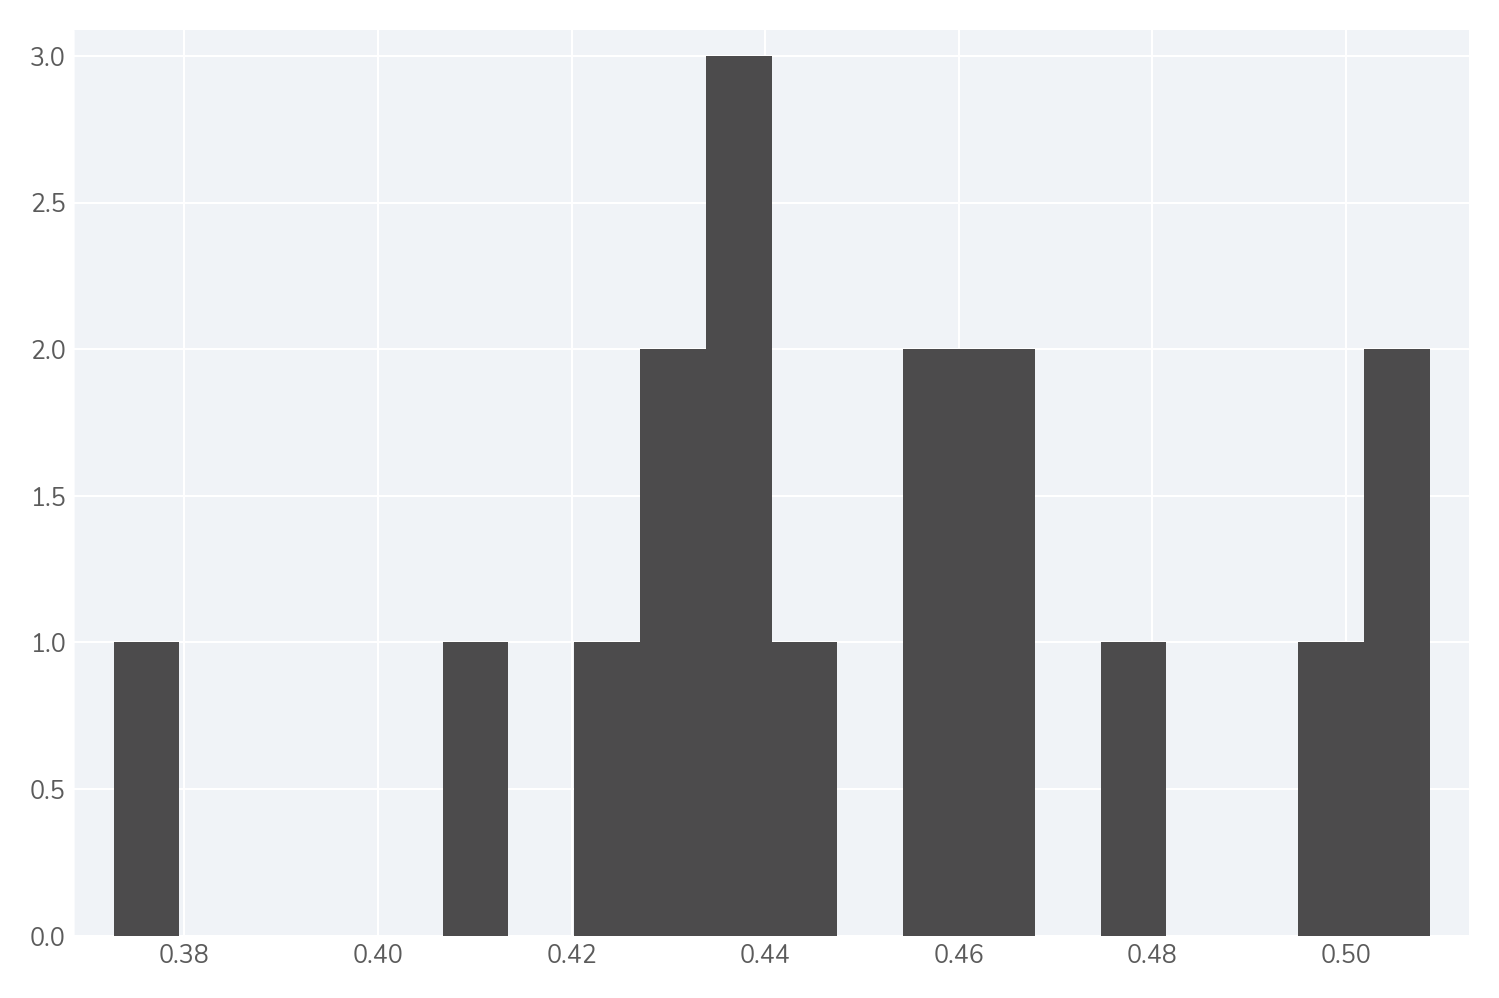

In [214]:
plt.hist(w, bins=20)

# Turning it into a function


In [ ]:
def tophat_filter(image, 
                  large_selem_diam=50, 
                  small_selem_diam=2,
                  threshold='otsu'):
    """
    Performs a series of tophat transforms to amplify phase contrast images for 
    segmentation

    Parameters
    ==========
    image : 2d-array
        The phase contrast image to be filtered. 
    large_selem_diam : int
        The diameter of the large disk structuring element used in generating the 
        black tophat transform. Default is 50 pixels.
    small_selem_diam : int
        The diameter of the small disk structuring element used in generating the 
        white tophat transform. Default is 2 pixels.
    threshold: str or float
        Threshold used for rough segmentation of cells. If of type `float`, 
        provided value is used. If `otsu`, Otsu's method is used. if 'none',
        no thresholding is applied.

    Returns 
    ========
    closed_image : 2d-array
        The filtered and thresholded (if desired) image. 
    """

    # Normalize the image. 
    im_norm = (image - image.min()) / (image.max() - image.min())

    # Perform background subtraction to correct of uneven illumination
    im_blur = skimage.filters.gaussian(image, 30)
    im_sub = im_norm - im_blur

    # Define structuring elements
    lg_selem = skimage.morphology.disk(large_selem_diam)
    sm_selem = skimage.morphology.disk(small_selem_diam)

    # Perform filtering and closing operations
    blk_tophat = skimage.morphology.black_tophat(im_sub, lg_selem)
    wht_tophat = skimage.morphology.white_tophat(blk_tophat, lg_selem)
    closing = scipy.ndimage.grey_closing(wht_tophat, footprint=sm_selem)

    if threshold == 'otsu':
        thresh = skimage.filter.threshold_otsu(closing)
    elif threshold == 'none':
        return closing
    else:
        thresh = skimage.filter.threshold_otsu(closing)
    return closing * (closing > thresh)

In [ ]:
def contour_segmentation(mask, intensity_image=None):
    """
    Segments an image using Laplacian of Gaussian and computes smoothed contours 
    of segmented objects. 
    """
    selem = skimage.morphology.square(2)
    blur = skimage.filters.gaussian(diff, 1)
    seg = size.image.log_segmentation(blur, radius=3, selem=selem, thresh=0.00001, 
                                    median_filt=False, label=False)
    seg = skimage.morphology.binary_erosion(seg, sm_selem)
    labeled = skimage.measure.label(seg)
    objs = np.zeros_like(crop)
    props = skimage.measure.regionprops(labeled)
    obj_ids = []
    bboxes = []
    cells = []
    contours = pd.DataFrame([])
    idx = 0
    for p in tqdm.tqdm(props):
        if ((p.area > 1E3) & (p.area < 5E3))  & (p.solidity > 0.9) & (p.eccentricity > 0.5):# & (p.intensity_max < 0.2):
            k = labeled==p.label
            objs += k
            obj_ids.append(p.label)
            rot = scipy.ndimage.rotate(labeled==p.label, -np.rad2deg(p.orientation), order=1) > 0
            relab = skimage.measure.label(rot.astype(int))
            rot_props = skimage.measure.regionprops(relab)
            level = 0
            cont = skimage.measure.find_contours(rot, level)[0]
            cx = cont[:, 1] #scipy.signal.savgol_filter(cont[:, 1], 3, 2, mode='wrap')
            cy = cont[:, 0] # scipy.signal.savgol_filter(cont[:, 0], 3, 2, mode='wrap')
            tck, u = scipy.interpolate.splprep([cx, cy], per=1, k=5, s=80)
            unew = np.arange(0, 1.0001, 0.0001)
            out = scipy.interpolate.splev(unew, tck)
            out = [list(out[0]), list(out[1])]
            dx = np.diff(out[0])
            ddx = np.diff(dx)
            dy = np.diff(out[1])
            ddy = np.diff(dy)
            k = (dx[:-1] * ddy  - dy[:-1] * ddx)/((dx[:-1]**2  + dy[:-1]**2)**(3/2))
            _df = pd.DataFrame([]) 
            _df['spl_x'] = out[0][:-2]
            _df['spl_y'] = out[1][:-2]
            _df['curvature'] = k
            _df['cell_id'] = idx
            idx += 1
            contours = pd.concat([contours, _df], sort=False)